In [1]:
import requests
import json
import pandas as pd
from openpyxl.workbook import Workbook
import sqlite3
import numpy as np
import matplotlib.pyplot as plt




In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [24]:
# Для скачивания данных
class ObjectsLoader:
    def __init__(self):
      self.object_dict=dict()
      self.index=0
      self.objects_list=[]
      self.offset_ = 1 # размер шага
      self.limit_ = 2000 # количество объектов в одном ответе api
      self.objids= []
      self.all_objcts=[]
      self.nashDom_RF_obj = None

    def getObjects(self):
      while True:
        url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={self.offset_}&limit={self.limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
        res = requests.get(url)
        objects_data = res.json()
        self.objects_list.extend(objects_data.get('data').get('list'))
        index+=1
        print(index)
        self.offset_= self.offset_ + self.limit_
        if len(objects_data.get('data').get('list'))<100:
          self.objects_list.extend(objects_data.get('data').get('list'))
        break

    def getIdObjects(self):
      #Получаем id всех объектов
      self.objids = [x.get('objId') for x in self.objects_list]

    def getDetailsObjects(self):
      #Делаем запросы по всем id
      for objid in self.objids:
        url1 = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/13391'
        res = requests.get(url1)
        res.json()
        self.all_objcts.extend(res.json())

    def make_Df_with_objects(self):
      print("Создан DataFrame")
      return pd.DataFrame(self.all_objcts)

    def get_df_with_objects(self):
        self.getObjects()
        self.getIdObjects()
        self.getDetailsObjects()
        self.nashDom_RF_obj = self.make_Df_with_objects()
        return self.nashDom_RF_obj


In [21]:
obj_loader = ObjectsLoader()
odf = obj_loader.get_df_with_objects()

In [4]:
class DataSaver:
    def save_to_csv(self, data, file_path):
        data.to_csv(file_path, index=False)

    def save_to_excel(self, data, file_path):
        data.to_excel(file_path, index=False)

    def save_to_sql(self, data, table_name):

        connection = sqlite3.connect(':memory:')
        cursor = connection.cursor()

        # Создаем таблицу с колонками, соответствующими ключам первого словаря в списке
        columns = ', '.join(data[0].keys())
        placeholders = ', '.join('?' * len(data[0]))
        cursor.execute(f"CREATE TABLE {table_name} ({columns})")

        # Вставляем данные
        for entry in data:
            values = tuple(entry.values())
            cursor.execute(f"INSERT INTO {table_name} VALUES ({placeholders})", values)

        connection.commit()
        return connection

    def save_from_db(self, connection, table_name, file_path):
        cursor = connection.cursor()
        cursor.execute(f"SELECT * FROM {table_name}")
        rows = cursor.fetchall()

        # Получаем заголовки столбцов
        columns = [description[0] for description in cursor.description]

        with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(columns)  # Записываем заголовки
            csv_writer.writerows(rows)  # Записываем строки данных
        connection.close()

    def save_to_pic(self, data, file_path):
      data.to_pickle(file_path,index=False)


In [23]:
saver = DataSaver()

In [ ]:
saver.save_to_csv(odf, 'odf.csv')
saver.save_to_excel(odf, 'odf.xlsx')
connection = saver.save_to_sql(odf, 'nash_dom_rf')
saver.save_from_db(connection, 'nash_dom_rf', 'nash_dom_rf.csv')


In [6]:
class DataProcessor:
    def __init__(self, filename):
        self.filename = filename

    def load_data(self):
        return pd.read_pickle(self.filename)

    def check_sequential_index(self, df):
        return df.index.is_monotonic_increasing and df.index[0] == 0

    def fill_missing_values(self, df):
        return df.fillna(0)

    def convert_data_types(self, df):
        conversions = {
            'objReady100PercDt': str,
            'address': str,
            'wallMaterialShortDesc': str,
            'region': int,
            'floorMin': int,
            'floorMax': int,
            'objElemLivingCnt': int,
            'pdId': int,
            'id': int,
            'hobjId': int,
            'objPriceAvg': float
        }
        for column, data_type in conversions.items():
            df[column] = df[column].astype(data_type)
        return df

    def calculate_average_prices(self, df):
        df_filtered = df[df['objPriceAvg'] != 0]
        return df_filtered.groupby('region')['objPriceAvg'].mean().sort_values(ascending=False)

    def sum_living_space(self, df):
        return df.groupby(['region', 'objReady100PercDt'])['objSquareLiving'].sum().reset_index()

    def calculate_region_statistics(self, df):
        return df.groupby('region').agg({
            'floorMax': lambda x: x[x != 0].mean(),
            'objElemLivingCnt': lambda x: x[x != 0].mean(),
            'objSquareLiving': lambda x: x[x != 0].mean(),
            'objElemParkingCnt': lambda x: x[x != 0].mean(),
            'objPriceAvg': lambda x: x[x != 0].mean(),
        })


In [7]:
processor = DataProcessor('df_nashdomrf.pkl')
df = processor.load_data()
print(processor.check_sequential_index(df))



True


In [8]:
df = processor.fill_missing_values(df)
df = processor.convert_data_types(df)
print(df)


          id  hobjId    pdId  region  \
0      13399   34754   28141      72   
1      13397   37201   28141      72   
2      13383   39024   28105      72   
3      13398   37165   28141      72   
4      13391   37219   28101      72   
...      ...     ...     ...     ...   
11709  56129  136843  794938      32   
11710  56132  136846  794938      32   
11711  56131  136845  794938      32   
11712  56130  136844  794938      32   
11713  51137  131791  582963      32   

                                                 address  floorMin  floorMax  \
0                        г Тюмень, ул Профсоюзная, д. 56         1         1   
1                        г Тюмень, ул Профсоюзная, д. 56         6        12   
2                        г Тюмень, ул Профсоюзная, д. 56         4        20   
3                        г Тюмень, ул Профсоюзная, д. 56         7        10   
4                        г Тюмень, ул Профсоюзная, д. 56         3        12   
...                                    

In [9]:
average_prices = processor.calculate_average_prices(df)
numbr_of_hous = processor.sum_living_space(df)
grouped_df = processor.calculate_region_statistics(df)

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 17,15

In [10]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns

In [55]:
class DataVisualizer:
    def __init__(self, data):
        self.data = data

    def plot_avg_price(self):

        self.data.sort_values(ascending=True).plot(kind='barh')
        plt.title('Средняя цена за кв.м по регионам', fontsize=16)
        plt.xlabel('Цена')
        plt.ylabel('Регионы')
        plt.show()

    def plot_housing_volume_by_region_and_year(self):
        pivot_df = self.data.pivot_table(
            values='objSquareLiving',
            index='region',
            columns='objReady100PercDt',
            aggfunc='sum',
            fill_value=0
        )
        pivot_df.plot(kind='bar', stacked=True, figsize=(16, 17))
        plt.title('Объем вводимого жилья по регионам и годам')
        plt.xlabel('Регион')
        plt.ylabel('Объем жилья')
        plt.legend(title='Год', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def plot_interactive_bar(self):
        pivot_df = self.data.pivot_table(
            values='objSquareLiving',
            index='region',
            columns='objReady100PercDt',
            aggfunc='sum',
            fill_value=0
        )
        fig = go.Figure()
        for column in pivot_df.columns:
            fig.add_trace(
                go.Bar(
                    x=pivot_df.index,
                    y=pivot_df[column],
                    name=str(column),
                    marker=dict(line=dict(color='#000000', width=1))
                )
            )
        fig.update_layout(
            barmode='stack',
            title='Объем вводимого жилья по регионам и годам',
            xaxis=dict(title='Регион'),
            yaxis=dict(title='Объем жилья'),
            legend_title=dict(text='Год'),
            hovermode="x"
        )
        iplot(fig)

    def plot_boxplots(self):
        grouped_df_reset = self.data.reset_index()
        plt.figure(figsize=(10, 6))
        for i, column in enumerate(grouped_df_reset.columns[1:], 1):
            plt.subplot(2, 3, i)
            sns.boxplot(y=column, data=grouped_df_reset)
        plt.tight_layout()
        plt.show()

    def plot_various_indicators_by_region(self):
        pokazateli = ['floorMax', 'objElemLivingCnt', 'objSquareLiving', 'objElemParkingCnt', 'objPriceAvg']
        xlabels = {
            'floorMax': 'Этажность',
            'objElemLivingCnt': 'Количество квартир',
            'objSquareLiving': 'Средняя жилая площадь, м²',
            'objElemParkingCnt': 'Количество парковочных мест',
            'objPriceAvg': 'Средняя цена за м²'
        }
        fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(20, 55))

        for i, pokazatel in enumerate(pokazateli):
            self.data[pokazatel].sort_values(ascending=True).plot(kind='barh', ax=axes[i])
            axes[i].set_title(f'{xlabels[pokazatel]} по регионам')
            axes[i].set_xlabel(xlabels[pokazatel])
            axes[i].set_ylabel('Регион')

        plt.tight_layout()
        plt.show()


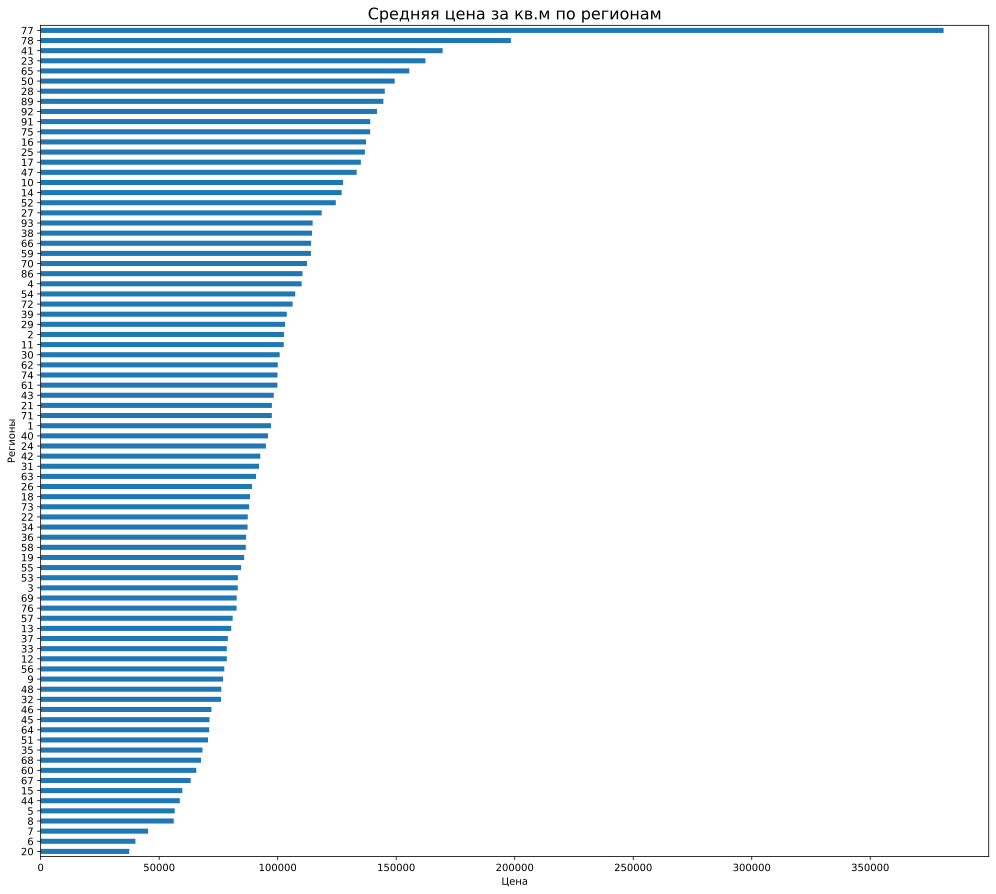

In [56]:
visual_plot_avg_price = DataVisualizer(average_prices)
visual_plot_avg_price.plot_avg_price()

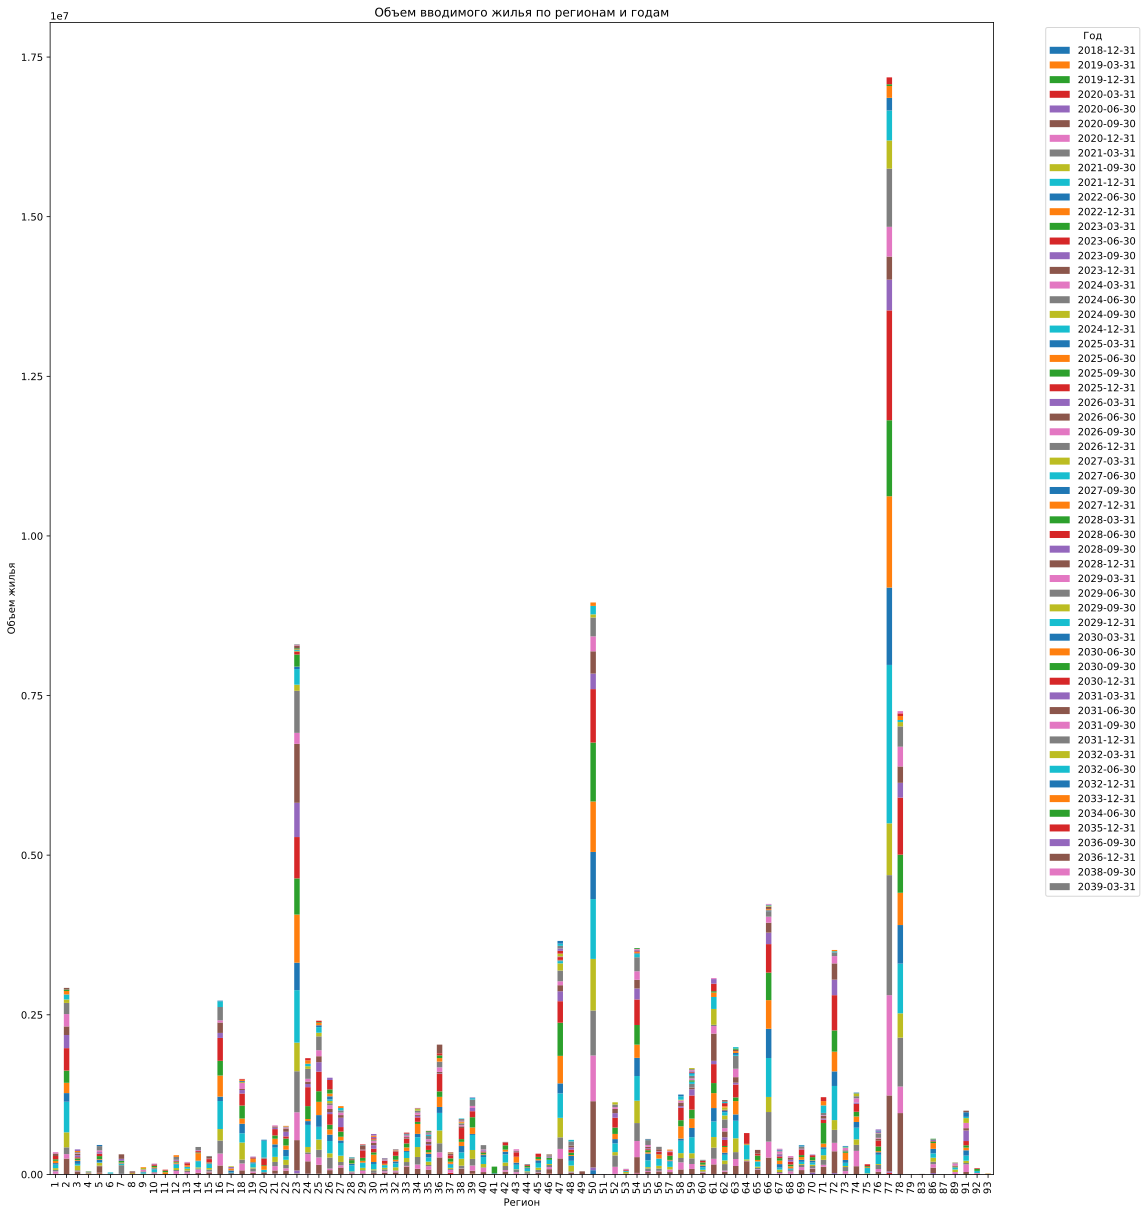

In [57]:
visual_numbr_of_hous=DataVisualizer(numbr_of_hous)
visual_numbr_of_hous.plot_housing_volume_by_region_and_year()
visual_numbr_of_hous.plot_interactive_bar()

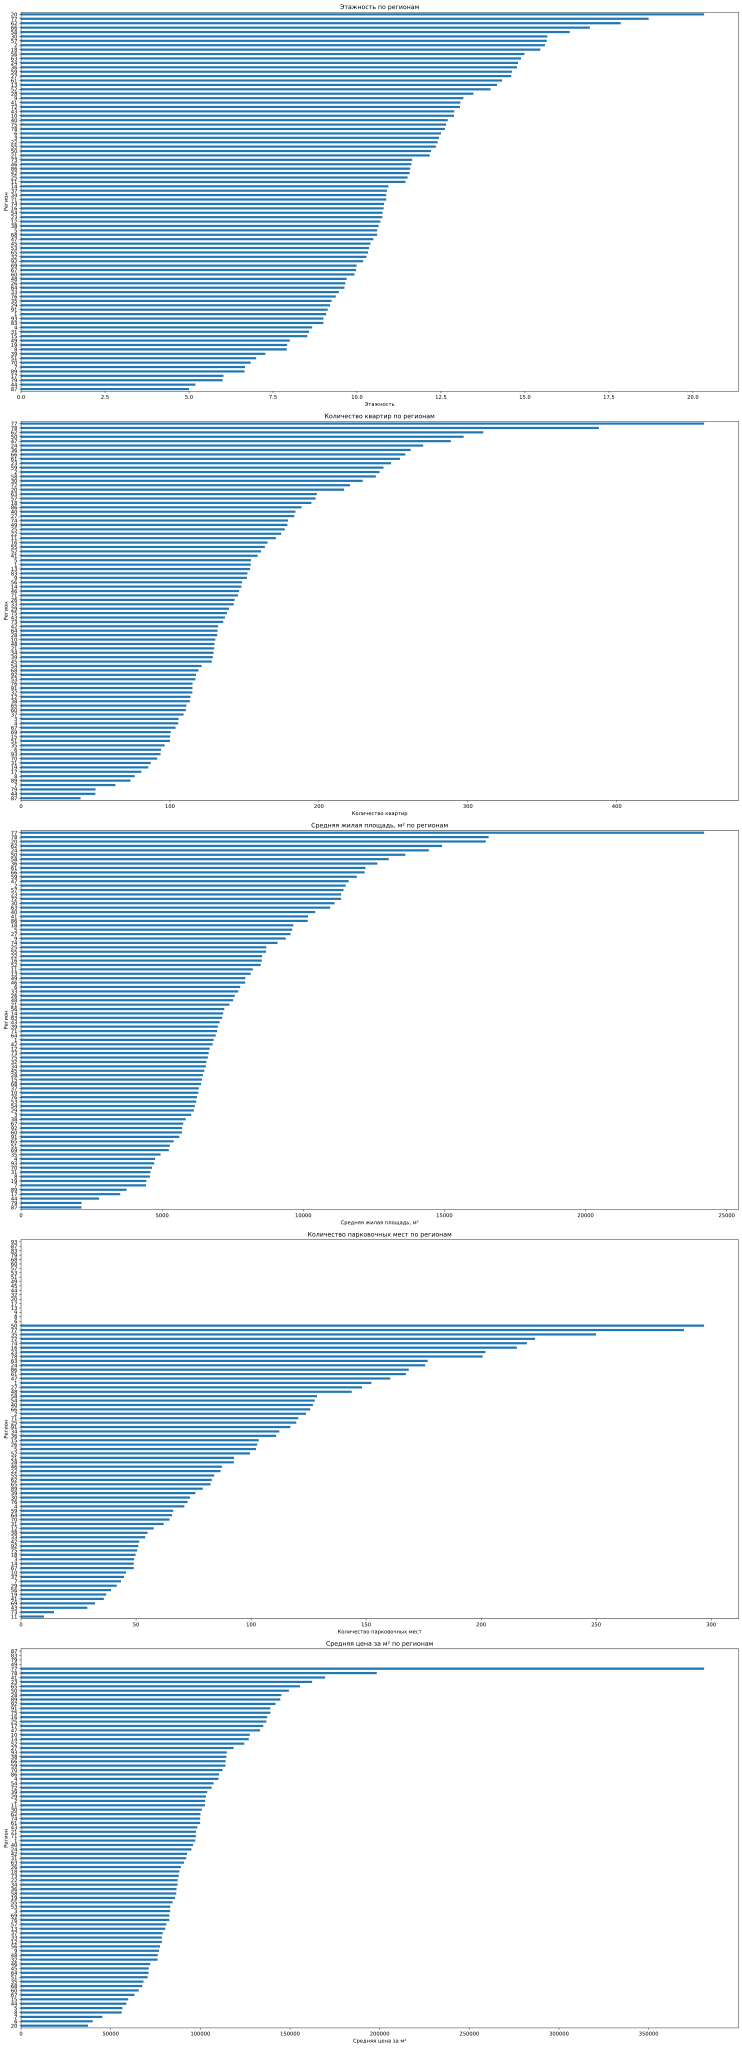

In [58]:
visual_grouped_df=DataVisualizer(grouped_df)
visual_grouped_df.plot_various_indicators_by_region()


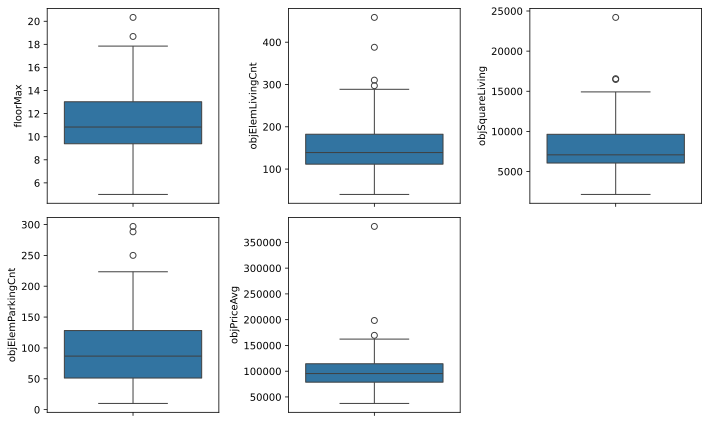

In [59]:
visual_grouped_df.plot_boxplots()